In [124]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
data = pd.read_csv("casestudy.csv")

In [126]:
data.columns

Index(['Unnamed: 0', 'customer_email', 'net_revenue', 'year'], dtype='object')

In [127]:
data.dtypes

Unnamed: 0          int64
customer_email     object
net_revenue       float64
year                int64
dtype: object

In [128]:
#  drop index column
data = data.drop('Unnamed: 0',1)

# strip
data['customer_email'] = data['customer_email'].str.strip()

In [129]:
data.dtypes

customer_email     object
net_revenue       float64
year                int64
dtype: object

In [130]:
data.head(5)

,customer_email,net_revenue,year
0,nhknapwsbx@gmail.com,249.92,2015
1,joiuzbvcpn@gmail.com,87.61,2015
2,ukkjctepxt@gmail.com,168.38,2015
3,gykatilzrt@gmail.com,62.40,2015
4,mmsgsrtxah@gmail.com,43.08,2015


In [131]:
data.describe()

,net_revenue,year
count,685927.000000,685927.000000
mean,125.647755,2016.027252
std,71.854528,0.837203
min,1.000000,2015.000000
25%,63.510000,2015.000000
50%,125.730000,2016.000000
75%,187.820000,2017.000000
max,250.000000,2017.000000


For each year we need the following information:
Total revenue for the current year
New Customer Revenue e.g., new customers not present in previous year only
Existing Customer Growth. To calculate this, use the Revenue of existing customers for current year –(minus) Revenue of existing customers from the previous year
Revenue lost from attrition
Existing Customer Revenue Current Year
Existing Customer Revenue Prior Year
Total Customers Current Year
Total Customers Previous Year
New Customers
Lost Customers

In [132]:
data['year'].value_counts()

2017    249987
2015    231294
2016    204646
Name: year, dtype: int64

In [133]:
# total revenue for current year and previous year 

rev_by_year = data.groupby('year').agg({'net_revenue': np.sum})
rev_by_year

,net_revenue
year,
2015,29036749.19
2016,25730943.59
2017,31417495.03


In [134]:
# total customers for current year and previous year
# considering there might be multiple orders from the same customer, we calculate the unique values of customers 

customer_by_year = data.groupby('year').agg({'customer_email': lambda x: x.unique().size})
customer_by_year

,customer_email
year,
2015,231294
2016,204646
2017,249987


In [135]:
by_year = rev_by_year.merge(customer_by_year, on='year', how='left')
by_year

,net_revenue,customer_email
year,,
2015,29036749.19,231294
2016,25730943.59,204646
2017,31417495.03,249987


Before start calculating existing customers, new customers, lost customers and the revenue related with them, I'd like to define 2015's new and existing customers as its total customers, as there is last no year to compare for 2015.

In [136]:
data_2015 = data[data['year']==2015]

New Customer and Revenue from New Customer

In [137]:
# new customer revenue 
# define a function identifying new customers 

def generate_new_customer_in_year(data, year):
    assert year in data['year'].unique()
    this_year_data = data[data['year'] == year]
    last_year_data = data[data['year'] == year - 1]
    this_year_new_data = this_year_data[~this_year_data['customer_email'].isin(last_year_data['customer_email'])]
    return this_year_new_data

In [138]:
# slicing new customers' orders from 2016 and 2017

new_2017 = generate_new_customer_in_year(data, 2017)
new_2016 = generate_new_customer_in_year(data, 2016)  

In [139]:
# new customer by year 

new_2017_customer = new_2017['customer_email'].unique().size
new_2016_customer = new_2016['customer_email'].unique().size
new_2015_customer = data_2015['customer_email'].unique().size

In [140]:
new_customer = [new_2015_customer,new_2016_customer,new_2017_customer]
by_year['New Customers'] = new_customer
by_year

,net_revenue,customer_email,New Customers
year,,,
2015,29036749.19,231294,231294
2016,25730943.59,204646,136891
2017,31417495.03,249987,173449


In [141]:
# new customer revenue of 2016 and 2017

rev_new_2017 = new_2017['net_revenue'].agg("sum")
rev_new_2016 = new_2016['net_revenue'].agg("sum")
rev_new_2015 = data_2015['net_revenue'].agg("sum")

In [143]:
new_customer_revenue = [rev_new_2015,rev_new_2016,rev_new_2017]
by_year['New Customer Revenue']=new_customer_revenue
by_year

,net_revenue,customer_email,New Customers,New Customer Revenue
year,,,,
2015,29036749.19,231294,231294,29036749.19
2016,25730943.59,204646,136891,17206366.90
2017,31417495.03,249987,173449,21769213.01


Existing Customer and revenue

In [144]:
# existing customer growth
# define a function identifying exisiting customers 

def generate_exist_customer_in_year(data, year):
    assert year in data['year'].unique()
    this_year_data = data[data['year'] == year]
    last_year_data = data[data['year'] == year - 1]
    exist_data = this_year_data[this_year_data['customer_email'].isin(last_year_data['customer_email'])]
    return exist_data

In [145]:
# slicing existing customers' orders from 2016 and 2017

exist_2017 = generate_exist_customer_in_year(data, 2017)
exist_2016 = generate_exist_customer_in_year(data, 2016)

In [146]:
# existing customer by year 

exist_2017_customer = exist_2017['customer_email'].unique().size
exist_2016_customer = exist_2016['customer_email'].unique().size
exist_2015_customer = data_2015['customer_email'].unique().size

In [147]:
exist_customer = [exist_2015_customer,exist_2016_customer,exist_2017_customer]
by_year['Existing Customers'] = exist_customer
by_year

,net_revenue,customer_email,New Customers,New Customer Revenue,Existing Customers
year,,,,,
2015,29036749.19,231294,231294,29036749.19,231294
2016,25730943.59,204646,136891,17206366.90,67755
2017,31417495.03,249987,173449,21769213.01,76538


In [148]:
# existing customer revenue of 2017, 2016 and 2015

rev_exist_2017 = exist_2017['net_revenue'].agg("sum")
rev_exist_2016 = exist_2016['net_revenue'].agg("sum")
rev_exist_2015 = data_2015['net_revenue'].agg("sum")

In [149]:
rev_exist_customer = [rev_exist_2015,rev_exist_2016,rev_exist_2017]
by_year['Existing Customer Revenue'] = rev_exist_customer
by_year

,net_revenue,customer_email,New Customers,New Customer Revenue,Existing Customers,Existing Customer Revenue
year,,,,,,
2015,29036749.19,231294,231294,29036749.19,231294,29036749.19
2016,25730943.59,204646,136891,17206366.90,67755,8524576.69
2017,31417495.03,249987,173449,21769213.01,76538,9648282.02


In [150]:
# existing customer revenue growth

rev_exist_growth_2017 = rev_exist_2017 - rev_exist_2016
rev_exist_growth_2016 = rev_exist_2017 - rev_exist_2015
rev_exist_growth_2015 = 0

In [151]:
rev_exist_growth = [rev_exist_growth_2015,rev_exist_growth_2016,rev_exist_growth_2017]
by_year['Existing Customer Growth'] = rev_exist_growth
by_year

,net_revenue,customer_email,New Customers,New Customer Revenue,Existing Customers,Existing Customer Revenue,Existing Customer Growth
year,,,,,,,
2015,29036749.19,231294,231294,29036749.19,231294,29036749.19,0.00
2016,25730943.59,204646,136891,17206366.90,67755,8524576.69,-19388467.17
2017,31417495.03,249987,173449,21769213.01,76538,9648282.02,1123705.33


Lost Customer and Revenue loss from churned customers 

In [152]:
# lost customer and revenue lost from attrition
# define a function identifying lost customers 

def generate_lost_customer_in_year(data, year):
    assert year in data['year'].unique()
    this_year_data = data[data['year'] == year]
    last_year_data = data[data['year'] == year - 1]
    lost_data = last_year_data[~last_year_data['customer_email'].isin(this_year_data['customer_email'])]
    return lost_data

In [153]:
# slicing existing customers' orders from 2016 and 2017

lost_2017 = generate_lost_customer_in_year(data, 2017)
lost_2016 = generate_lost_customer_in_year(data, 2016)


In [154]:
# lost customer by year 

lost_2017_customer = lost_2017['customer_email'].unique().size
lost_2016_customer = lost_2016['customer_email'].unique().size
lost_2015_customer = 0

In [155]:
lost_customers= [lost_2015_customer,lost_2016_customer,lost_2017_customer]
by_year['Lost Customers'] = lost_customers
by_year

,net_revenue,customer_email,New Customers,New Customer Revenue,Existing Customers,Existing Customer Revenue,Existing Customer Growth,Lost Customers
year,,,,,,,,
2015,29036749.19,231294,231294,29036749.19,231294,29036749.19,0.00,0
2016,25730943.59,204646,136891,17206366.90,67755,8524576.69,-19388467.17,163539
2017,31417495.03,249987,173449,21769213.01,76538,9648282.02,1123705.33,128108


In [156]:
# lost customer revenue of 2016 and 2017

rev_lost_2017 = lost_2017['net_revenue'].agg("sum")
rev_lost_2016 = lost_2016['net_revenue'].agg("sum")
rev_lost_2015 = 0

In [157]:
revenue_lost = [rev_lost_2015,rev_lost_2016,rev_lost_2017]
by_year['Revenue lost from attrition']=revenue_lost
by_year

,net_revenue,customer_email,New Customers,New Customer Revenue,Existing Customers,Existing Customer Revenue,Existing Customer Growth,Lost Customers,Revenue lost from attrition
year,,,,,,,,,
2015,29036749.19,231294,231294,29036749.19,231294,29036749.19,0.00,0,0.00
2016,25730943.59,204646,136891,17206366.90,67755,8524576.69,-19388467.17,163539,20551216.15
2017,31417495.03,249987,173449,21769213.01,76538,9648282.02,1123705.33,128108,16146518.63


In [158]:
by_year = pd.DataFrame(by_year)
by_year = by_year.rename({'net_revenue': 'Net Revenue', 'customer_email': 'Customers'},axis='columns')
by_year

,Net Revenue,Customers,New Customers,New Customer Revenue,Existing Customers,Existing Customer Revenue,Existing Customer Growth,Lost Customers,Revenue lost from attrition
year,,,,,,,,,
2015,29036749.19,231294,231294,29036749.19,231294,29036749.19,0.00,0,0.00
2016,25730943.59,204646,136891,17206366.90,67755,8524576.69,-19388467.17,163539,20551216.15
2017,31417495.03,249987,173449,21769213.01,76538,9648282.02,1123705.33,128108,16146518.63


<AxesSubplot:title={'center':'Orders by Year'}, ylabel='customer_email'>

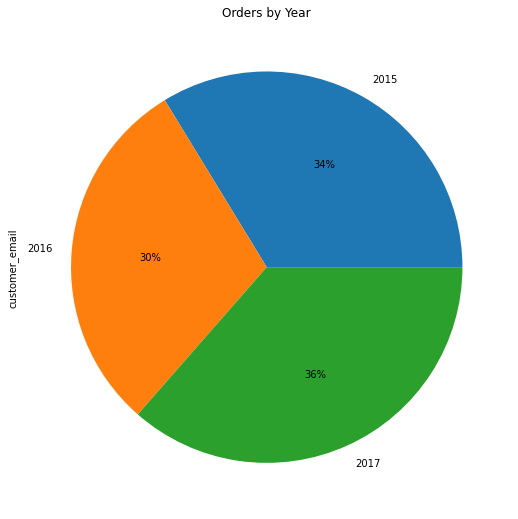

In [159]:
# visualisation and observation 

# orders by year 
data.groupby('year')['customer_email'].count().plot(title='Orders by Year',kind='pie',figsize=[16,9],autopct='%.0f%%')

As we can see from the pie chart and below bar chart - net revenue for each year, although orders/revenues are relatively evenly distributed by 1/3 per year, those from 2015 and 2017 have a larger percent. 2016 has the least amount of orders/revenue, while 2017 has the largest percentage(36%) orders, with the highest revenue 31,417,495.

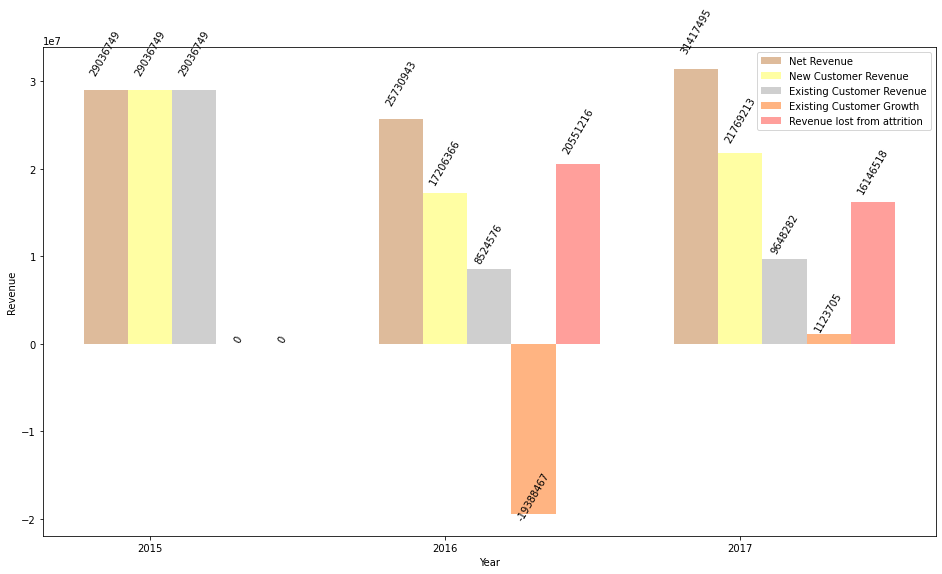

In [160]:
# revenue, new customer revenue, existing customer revenue by year

N = 3
ind = np.arange(3)  
width = 0.15     

plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
ax = fig.add_subplot(111)

yvals = by_year['Net Revenue']
rects1 = ax.bar(ind, yvals, width, color=sns.color_palette('pastel')[5])
zvals = by_year['New Customer Revenue']
rects2 = ax.bar(ind+width, zvals, width, color=sns.color_palette('pastel')[8])
kvals = by_year['Existing Customer Revenue']
rects3 = ax.bar(ind+width*2, kvals, width, color=sns.color_palette('pastel')[7])
svals = by_year['Existing Customer Growth']
rects4 = ax.bar(ind+width*3, svals, width, color=sns.color_palette('pastel')[1])
hvals = by_year['Revenue lost from attrition']
rects5 = ax.bar(ind+width*4, hvals, width, color=sns.color_palette('pastel')[3])

ax.set_ylabel('Revenue')
ax.set_xlabel('Year')
ax.set_xticks(ind+width)
ax.set_xticklabels(('2015','2016','2017'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0],rects5[0]), ('Net Revenue', 'New Customer Revenue', 'Existing Customer Revenue','Existing Customer Growth','Revenue lost from attrition'))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),rotation=60,
                ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5) 

plt.show()

From above chart, we can tell that for 2016 and 2017, main revenue comes from new customer, revenue from new customers is significantly higher than existing customer. We shall compared this observation with the amount of new and existing customers in below chart, so we can find out if the lower existing customer value comes from lower revenue per customer or fewer existing customers. 
Another point we shall emphasize is - the existing customer growth is very low, which means the company shall pay attention on not only customer retention but also how to increase the transaction value/revenue per customer. Especially for 2016, the existing customer growth is almost -20 million, with revenue lost from attrition exceeding 20 million as well.This finding indicates that large amount of customers left, and the remaining customers' purchasing power or willingness also declined a lot. These 2 factors explained and significantly reflected the fact that, 2016 has the least order/revenue among all the years. The company needs to figure out if anything special happened in 2016, e.g. change in pricing or product, strong new competitors, and weaker customer relationship.    

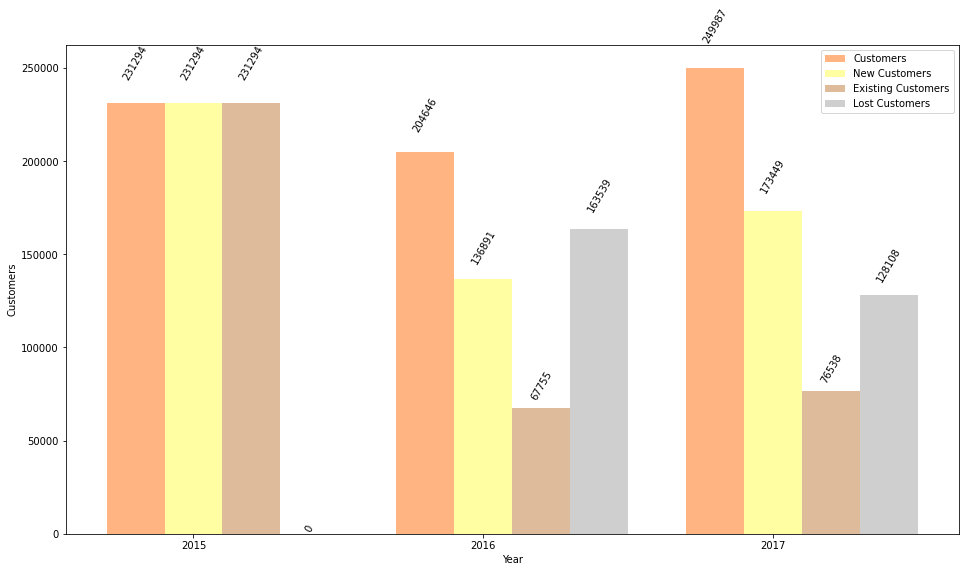

In [161]:
# customers, new customer, existing customer revenue, lost customer by year


N = 3
ind = np.arange(N)  
width = 0.2    

plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
ax = fig.add_subplot(111)

hvals = by_year['Customers']
rects1 = ax.bar(ind, hvals, width, color=sns.color_palette('pastel')[1])
yvals = by_year['New Customers']
rects2 = ax.bar(ind+width, yvals, width, color=sns.color_palette('pastel')[8])
zvals = by_year['Existing Customers']
rects3 = ax.bar(ind+width*2, zvals, width, color=sns.color_palette('pastel')[5])
kvals = by_year['Lost Customers']
rects4 = ax.bar(ind+width*3, kvals, width, color=sns.color_palette('pastel')[7])


ax.set_ylabel('Customers')
ax.set_xlabel('Year')
ax.set_xticks(ind+width)
ax.set_xticklabels(('2015','2016','2017'))
ax.legend((rects1[0], rects2[0], rects3[0],rects4[0]), ('Customers','New Customers', 'Existing Customers', 'Lost Customers'))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),rotation=60,
                ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()

From above charts, we can tell that the trends of customer engagement, customer retention, and customer attrition overlap with those of revenue. New customers of 2016 and 2017 almost double existing customers. This explains why the revenue from new customers is also significantly higher than existing customers. Meanwhile, 2016's lost customers also doubled the remaining customers, which explains the sharp revenue loss from attrition. Therefore we can conclude that compared with increasing revenue per customer/transaction value, it's more important to maintain existing customers.Customer retention shall have the highest priority in our business.

<AxesSubplot:title={'center':'Revenue by Customer'}, xlabel='customer_email'>

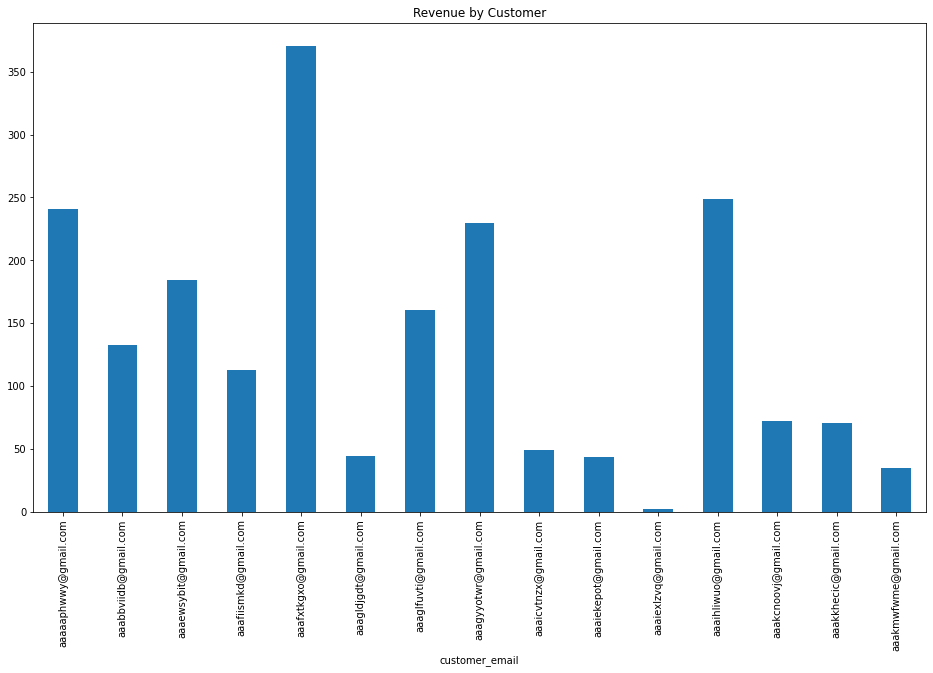

In [162]:
# see if there are key customers contributing to most orders and revenue 

data.groupby('customer_email')['net_revenue'].sum().head(15).plot(title='Revenue by Customer',kind='bar',figsize=[16,9])

<AxesSubplot:title={'center':'Revenue Per Customer Distribution'}, ylabel='Frequency'>

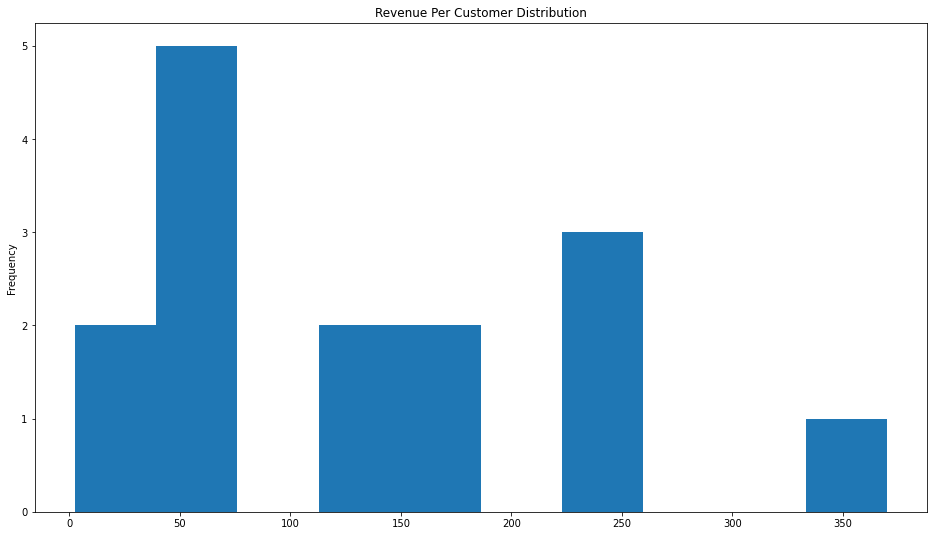

In [163]:
# see frequent revenue per customer 

data.groupby('customer_email')['net_revenue'].sum().head(15).plot(title='Revenue Per Customer Distribution',kind='hist',figsize=[16,9])

From the distribution chart we can tell some key customers have contributed more to our revenue, and the top revenues they contribute is at roughly 350 and then 250. Among all the revenue amount contributed by individual customers, 50 and 250 are more commonly seen. 

In [166]:
# output result
by_year = by_year.replace(0, np.nan)
by_year

,Net Revenue,Customers,New Customers,New Customer Revenue,Existing Customers,Existing Customer Revenue,Existing Customer Growth,Lost Customers,Revenue lost from attrition
year,,,,,,,,,
2015,29036749.19,231294,231294,29036749.19,231294,29036749.19,NaN,NaN,NaN
2016,25730943.59,204646,136891,17206366.90,67755,8524576.69,-19388467.17,163539.0,20551216.15
2017,31417495.03,249987,173449,21769213.01,76538,9648282.02,1123705.33,128108.0,16146518.63



While filling in the information for 2015, we intentionally filled 0 to make the analysis easier. To make it more accurate, we replace it with Nan as the missing information comes from the fact that 2015 doesn't have a last year to compare with. 0 may cause misinterpretation in the future.  

In [167]:
by_year.to_csv("Case2_Annual_Analysis.csv")